# Generating simple cross sections

Here we show how you can generate collisional cross sections using the tools from `parfis` module. Since the collisional therms span for a wide range of energy (velocity), we must use nonlinear function tabulation.

$$\newcommand{\Ang}{\unicode{xC5}}$$

## Constant and step collision cross section

Particle's velocity is bounded in value, as it must not traverse more than a cell-length in a single timestep. The larger the cell component (x, y or z) is, the greater maximum velocity it can support. In order to satisfy the constrain for all components, we must choose the smallest component as the base for the calculation of the maximum allowed velocity magnitude. Let's take the following simulation settings:

$$
\begin{align*} 
  C = C_x &= C_y = C_z = 0.02 \mathrm{m}, \\
  \Delta t &= 10^{-10} \mathrm{s}, \\
   m_e &= 9.1093837 \cdot 10^{-31} \mathrm{kg},
\end{align*}
$$

for the cell size, timestep and particle mass (electron). We can calculate the maximum velocity component as $v_m = C/\Delta t$ from which we get the maximum kinetic energy that can be simulated per electron as:

$$
\epsilon_{m} = \frac{m_e v^2}{2} = \frac{m_e C^2}{2 \Delta t ^2} = 1.822\cdot10^{-14} \mathrm{J} \quad (\equiv 113.713 \mathrm{keV}).
$$

From this we see that the x vector can be in the range from 0 to 114keV.

### Constant cross section 

We will generate elastic cross section with a constant value of:

$$\sigma_e = 6 \Ang^2 \quad (\equiv 6.0 \cdot 10^{-20} \mathrm{m^2}).$$

### Step cross section

For the step cross section we have a point at which the value has a discontinity. This cross section will have a threshold, and the collision process is inelastic. The function of the step cross section is:

$$ \sigma_i = 
\begin{cases}
  0 \quad &x < 0.2 \mathrm{eV} \\
  3  \mathrm{\Ang^2} \quad &x \geq 0.2 \mathrm{eV}.
\end{cases}
$$

In [1]:
import parfis as pfs
import matplotlib.pyplot as plt
import numpy as np

nbin = 10000 # number of bins
xmax = 114_000
dx = np.log10(xmax)/nbin # dx for the linear axis
xvec = [np.power(i*dx, 10) for i in range(nbin)]

def sigma_e(x):
    return 6

def sigma_i(x):
    if x<0.2:
        return 0
    else:
        return 3

xl = np.asarray(xvec)
yle = np.ndarray(len(xvec), dtype=float)
yli = np.ndarray(len(xvec), dtype=float)
for i in range(len(xvec)):
    yle[i] = sigma_e(xvec[i])
    yli[i] = sigma_i(xvec[i])
ylt = yle + yli

Let's plot the cross section with linear tabulation, with log x-axis scale.

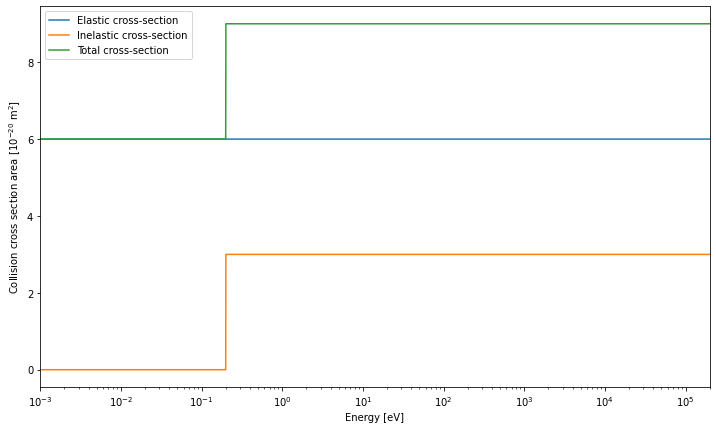

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))  

ax.plot(xl, yle, label="Elastic cross-section")
ax.plot(xl, yli, label="Inelastic cross-section")
ax.plot(xl, ylt, label="Total cross-section")
ax.set_xscale("log")
ax.set_xlim(0.001, 200_000)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Collision cross section area [$10^{-20}$ $\mathrm{m}^2$]")
ax.legend()

plt.show()

### Collision frequency

The probability for a collision in a time $\Delta t$ is given as:

$$
p(t, t + \Delta t) = 1 - \exp( -N \sigma_t  v \Delta t ) = 1 - \exp(-\nu_t \Delta_t),
$$

where $N$ is the number of gas particles, $v$ is the velocity magnitude of the projectile particle and $\nu_t$ is the collisional frequency. We can express the above collisional frequencies by using the formula $v = \sqrt{2 \epsilon / m_e}$.

$$
\nu(\epsilon) = N \sigma(\epsilon) \sqrt{2 \epsilon/m_e}.
$$

We calculate collisional frequency for Avogadro number of particles $N_A$.

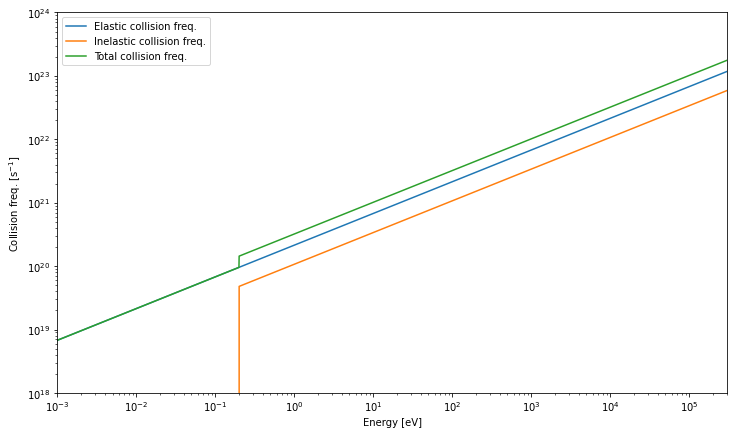

In [3]:
eVJ = 1.602176634e-19
me = 9.1093837e-11  # since we have y in units of A^2 (scale 1e-20m) and me in kg (scale 1e-31)
Na = 6.02214076e23

fle = Na*yle*np.sqrt(2*xl*eVJ/me)
fli = Na*yli*np.sqrt(2*xl*eVJ/me)
flt = Na*ylt*np.sqrt(2*xl*eVJ/me)


fig, ax = plt.subplots(1, 1, figsize=(12, 7))

ax.plot(xl, fle, label="Elastic collision freq.")
ax.plot(xl, fli, label="Inelastic collision freq.")
ax.plot(xl, flt, label="Total collision freq.")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.001, 300_000)
ax.set_ylim(1e18, 1e24)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Collision freq. [$\mathrm{s}^{-1}$]")
ax.legend()

plt.show()

## Non-linear function tabulation

Since we are dealing with extremely nonlinear functions we must perform nonlinear tabulation. The mechanism for tabulating is to give ranges and bins for every range of the tabulation. Ranges are connected, for example the range from 0-1 and from 1-10 is written as a list [1, 10]. It can be said that we only write the range's end value, and the startin value is taken to be the previos number in the list. The first element is always zero. Let's see this tabulation for 5 ranges covering the energies from 0 to 342keV, and for 8000 overall datapoints. 

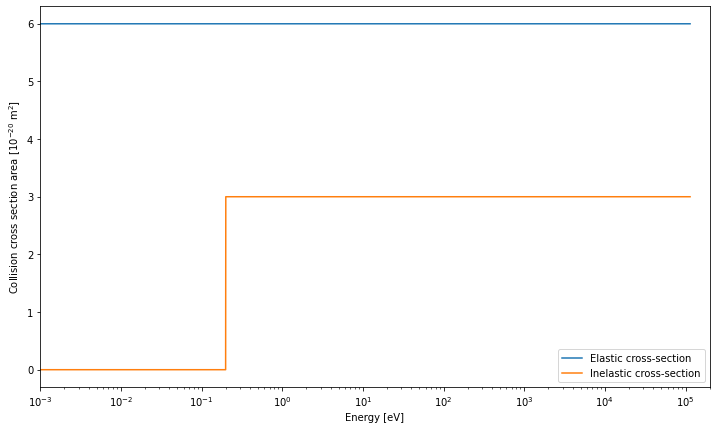

In [4]:
ranges = [   1,   10,  100, 1000, 10000, 114000]
nbins =  [1000, 1000, 1000, 1000,  1000,   3000]

x, ye = pfs.generateCrossSection(sigma_e, ranges, nbins)
x, yi = pfs.generateCrossSection(sigma_i, ranges, nbins)

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

ax.plot(x, ye, label="Elastic cross-section")
ax.plot(x, yi, label="Inelastic cross-section")

ax.set_xscale("log")
ax.set_xlim(0.001, 200_000)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Collision cross section area [$10^{-20}$ $\mathrm{m}^2$]")
ax.legend()

plt.show()

## Simulation demo

The parfis library is written to accept this nonlinear tabulation for the cross section data definitions. If we load the following two files, we can represent the collision frequencies as they are calculated in the c++ code. We load the predefined configuration file that loads generated files as given above.

In [5]:
ranges = [   1,   10,  100, 1000, 21000]
nbins =  [1000, 1000, 1000, 1000,  1000]
pfs.generateCrossSection(sigma_e, ranges, nbins, file="./elastic.csv")
pfs.generateCrossSection(sigma_i, ranges, nbins, file="./inelastic.csv")

pfs.Parfis.load_lib()
id = pfs.Parfis.newParfis()
pfs.Parfis.setConfigFromFile(id, "./gasCollisionDefinition.ini")
pfs.Parfis.loadCfgData(id)
pfs.Parfis.loadSimData(id)
pfs.Parfis.setPySimData(id)
pfs.Parfis.setPyCfgData(id)
ptrCfgData = pfs.Parfis.getPyCfgData(id)
ptrSimData = pfs.Parfis.getPySimData(id)

Successfully loaded lib file: libparfis64.so


We have the following data for the gas density in mol per square meter and in particles per square meter. We will need the particle mass (in the config file is given in AMU), as weel as the cell size in meters.

In [6]:
Na = 6.02214076e23 # Avogadro number = number of particles in one mol
JeV = 6.2415090744608e18 # Joules to electron volt
Nmol = ptrSimData.gasVec.ptr[0].molDensity
N = Nmol*Na
mamu = ptrSimData.specieVec.ptr[0].amuMass
mkg = ptrSimData.specieVec.ptr[0].mass
C = ptrCfgData.cellSize[0]
maxVel = ptrSimData.specieVec.ptr[0].maxVel
maxEcode = ptrSimData.specieVec.ptr[0].maxEv
maxEcalc = 0.5*mkg*maxVel**2*JeV
print(f"Gas density [mol/m^3] = {Nmol:.3e}")
print(f"Gas density [particles/m^3] = {N:.3e}")
print(f"Particle mass [AMU]: {mamu:.3e}")
print(f"Particle mass [kg]: {mkg:.3e}")
print(f"Cell size [m]: {C}")
print(f"Maximum velocity [m/s]: {maxVel:.3e}")
print(f"Maximum energy from code [eV]: {maxEcode:.3e}")
print(f"Maximum energy from calculation [eV]: {maxEcalc:.3e}")


Gas density [mol/m^3] = 1.661e-01
Gas density [particles/m^3] = 1.000e+23
Particle mass [AMU]: 4.000e+00
Particle mass [kg]: 6.642e-27
Cell size [m]: {x: 0.001, y: 0.001, z: 0.001}
Maximum velocity [m/s]: 1.000e+06
Maximum energy from code [eV]: 2.073e+04
Maximum energy from calculation [eV]: 2.073e+04


Now it is obvious why we use the value of 21keV for tabulating the cross section, as it is given above. Let's see how this cross sections are tabulated inside the parfis lib.